In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ================================

## Iterating over Deep Learning Models using Merlin Models

In this example notebook, we use the Ali-CCP: Alibaba Click and Conversion Prediction dataset to build our recommender system models. To download the Ali-CCP training and test datasets visit [tianchi.aliyun.com](https://tianchi.aliyun.com/dataset/dataDetail?dataId=408#1). We have curated the raw dataset via this [script]() and generated the parquet files that we will use in this example. Note that the `Ali-CCP` dataset has `click` and `conversion` target columns but we only focus on building different ranking models with binary target column `click`.

We'll define several popular deep learning-based model architectures, train, and evaluate them and show how Merlin Models simplifies and eases this common and iterative process."

### Learning objectives
- Preparing the data with NVTabular
- Training different deep learning-based recommender models with Merlin Models

### Importing Libraries

Let's start with importing the libraries that we'll use in this notebook.

In [2]:
import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
from nvtabular import ops as nvt_ops
from merlin.models.utils.example_utils import workflow_fit_transform, save_results, create_bar_chart

from merlin.schema.tags import Tags

import merlin.models.tf as mm

from merlin.io.dataset import Dataset
from merlin.schema.io.tensorflow_metadata import TensorflowMetadata

import tensorflow as tf

2022-03-25 18:07:15.703196: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 18:07:16.833264: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2022-03-25 18:07:16.833404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16254 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:15:00.0, compute capability: 7.0


### Feature Engineering with NVTabular

When we work on a new recommender systems, we explore the dataset, first. In doing so, we define our input and output paths. We will use the parquet files in the test folder to validate our trained model.

In [3]:
DATA_FOLDER = os.environ.get("DATA_FOLDER", "/workspace/data/")
train_path = os.path.join(DATA_FOLDER, "train", "*.parquet")
valid_path = os.path.join(DATA_FOLDER, "test", "*.parquet")
output_path = "/workspace/data/processed"

Our dataset has only categorical features. Below, we create continuous features using target encoding (TE) technique. Target Encoding calculates the statistics from a target variable grouped by the unique values of one or more categorical features. For example, in a binary classification problem, TE calculates the conditional probability that the target is true for each category value- a simple mean. To learn more about TE, visit this [medium blog](https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784).

We use a utility function, `workflow_fit_transform` perform to fit and transform steps on the raw dataset applying the operators defined in the NVTabular workflow pipeline below, and also save our workflow model. After fit and transform, the processed parquet files are saved to `output_path`.

In [4]:
%%time

user_id = ["user_id"] >> nvt_ops.Categorify(freq_threshold=5) >> nvt_ops.TagAsUserID()
item_id = ["item_id"] >> nvt_ops.Categorify(freq_threshold=5) >> nvt_ops.TagAsItemID()
targets = ["click"] >> nvt_ops.AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])

add_feat = [
    "user_item_categories",
    "user_item_shops",
    "user_item_brands",
    "user_item_intentions",
    "item_category",
    "item_shop",
    "item_brand",
] >> nvt_ops.Categorify()

te_feat = (
    ["user_id", "item_id"] + add_feat
    >> nvt_ops.TargetEncoding(["click"], kfold=1, p_smooth=20)
    >> nvt_ops.Normalize()
)

outputs = user_id + item_id + targets + add_feat + te_feat

# Remove rows where item_id==0 and user_id==0
outputs = outputs >> nvt_ops.Filter(f=lambda df: (df["item_id"] != 0) & (df["user_id"] != 0))

workflow_fit_transform(outputs, train_path, valid_path, output_path)

/usr/local/lib/python3.8/dist-packages/cudf/core/dataframe.py:1253: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


CPU times: user 23.9 s, sys: 29 s, total: 52.9 s
Wall time: 56.4 s


### Training Recommender Models

NVTabular exported the schema file of our processed dataset. The `schema.pbtxt` is a protobuf text file contains features metadata, including statistics about features such as cardinality, min and max values and also tags based on their characteristics and dtypes (e.g., categorical, continuous, list, item_id). The metadata information is loaded from schema and their tags are used to automatically set the parameters of Merlin Models. In other words, Merlin Models relies on the schema object to automatically build all necessary input and output layers.

In [5]:
# define schema object
schema = TensorflowMetadata.from_proto_text_file(output_path + "/train/").to_merlin_schema()

In [6]:
target_column = schema.select_by_tag(Tags.TARGET).column_names[0]
target_column

'click'

We can print out all the features that are included in the `schema.pbtxt` file.

In [7]:
schema.column_names

['user_id',
 'item_id',
 'click',
 'user_item_categories',
 'user_item_shops',
 'user_item_brands',
 'user_item_intentions',
 'item_category',
 'item_shop',
 'item_brand',
 'TE_user_item_categories_click',
 'TE_user_item_shops_click',
 'TE_user_item_brands_click',
 'TE_user_item_intentions_click',
 'TE_item_category_click',
 'TE_item_shop_click',
 'TE_item_brand_click',
 'TE_user_id_click',
 'TE_item_id_click']

### Initialize Dataloaders

We're ready to start training, for that, we create our dataset objects, and under the hood we use Merlin `BatchedDataset` class for reading chunks of parquet files. `BatchedDataset` asynchronously iterate through CSV or Parquet dataframes on GPU by leveraging an NVTabular `Dataset`. To read more about Merlin optimized dataloaders visit [here](https://github.com/NVIDIA-Merlin/models/blob/main/merlin/models/tf/dataset.py#L141).

In [13]:
batch_size = 16 * 1024
LR = 0.003

In [14]:
train = Dataset(os.path.join(output_path + "/train", "*.parquet"), part_size="500MB")
valid = Dataset(os.path.join(output_path + "/valid", "*.parquet"), part_size="500MB")

### NCF Model

We will first build and train a Neural Collaborative Filtering (NCF) model. Neural Collaborative Filtering [(NCF)](https://arxiv.org/pdf/1708.05031.pdf) Model  architecture explores neural network architectures for collaborative filtering, in other words explores the use of deep neural networks for learning the interaction function from data.

NCF feed categorical features into embedding layer, concat the embedding outputs and add multiple hidden layers via its MLP layer tower as seen in the figure. GMF and MLP uses separate user and item embeddings, and then outputs of their interactions from GMF Layer and MLP Layer are concatenated and fed to the final NeuMF (Neural Matrix Factorisation) layer.

<img src="./images/ncf.png"  width="30%">

<a href="https://arxiv.org/pdf/1708.05031.pdf">Image Source: NCF paper</a>

With `schema` object we enable NCF model easily to recognize item_id and user_id columns (defined in the schema.pbtxt with corresponding tags). Input block of embedding layers will be generated using item_id and user_id as seen in the Figure.

In [15]:
model = mm.benchmark.NCFModel(
    schema,
    embedding_dim=64,
    mlp_block=mm.MLPBlock([128, 64]),
    prediction_tasks=mm.BinaryClassificationTask(target_column, metrics=[tf.keras.metrics.AUC()]),
)

In [16]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False)
model.fit(train, validation_data=valid, batch_size=batch_size)

2022-03-25 17:59:13.755461: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2208/2209 [============================>.] - ETA: 0s - auc: 0.5371 - loss: 0.2201 - regularization_loss: 0.0000e+00 - total_loss: 0.2201

2022-03-25 18:00:27.333687: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/then/_0/cond/cond/branch_executed/_125


2209/2209 [==============================] - 98s 36ms/step - auc: 0.5371 - loss: 0.2200 - regularization_loss: 0.0000e+00 - total_loss: 0.2200 - val_auc: 0.5008 - val_loss: 0.1336 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.1336
CPU times: user 2min 38s, sys: 22.8 s, total: 3min 1s
Wall time: 1min 39s


Let's save our accuracy results

In [17]:
save_results("NCF", model)

### MLP Model

Now we will change our model to Multi-Layer Percepton (MLP) model. MLP models feed categorical features into embedding layer, concat the embedding outputs and add multiple hidden layers.

<img src="./images/mlp.png"  width="30%">

Steps:

- Change the model to MLP model
- Rerun the pipeline from there from model.fit

In [18]:
# uses default embedding_dim = 64
model = mm.MLPBlock([64, 32]).to_model(
    schema,
    prediction_tasks=mm.BinaryClassificationTask(target_column, metrics=[tf.keras.metrics.AUC()]),
)

In [19]:
%%time

opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False)
model.fit(train, validation_data=valid, batch_size=batch_size)

2208/2209 [============================>.] - ETA: 0s - auc_1: 0.6208 - loss: 0.1865 - regularization_loss: 0.0000e+00 - total_loss: 0.1865

2022-03-25 18:01:56.220502: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/then/_0/cond/cond/branch_executed/_140


2209/2209 [==============================] - 91s 38ms/step - auc_1: 0.6208 - loss: 0.1864 - regularization_loss: 0.0000e+00 - total_loss: 0.1864 - val_auc_1: 0.5698 - val_loss: 0.1384 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.1384
CPU times: user 3min 9s, sys: 31.7 s, total: 3min 41s
Wall time: 1min 31s


In [20]:
save_results("MLP", model)

### DLRM Model

Deep Learning Recommendation Model [(DLRM)](https://arxiv.org/abs/1906.00091) architecture is a popular neural network model originally proposed by Facebook in 2019. The model was introduced as a personalization deep learning model that uses embeddings to process sparse features that represent categorical data and a multilayer perceptron (MLP) to process dense features, then interacts these features explicitly using the statistical techniques proposed in [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5694074).

![DLRM](./images/DLRM.png)


DLRM accepts two types of features: categorical and numerical. 
- For each categorical feature, an embedding table is used to provide dense representation to each unique value. 
- For numerical features, they are fed to model as dense features, and then transformed by a simple neural network referred to as "bottom MLP". This part of the network consists of a series of linear layers with ReLU activations. 
- The output of the bottom MLP and the embedding vectors are then fed into the dot product interaction operation (see Pairwise interaction step). The output of "dot interaction" is then concatenated with the features resulting from the bottom MLP (we apply a skip-connection there) and fed into the "top MLP" which is also a series of dense layers with activations ((a fully connected NN). 
- The model outputs a single number (here we use sigmoid function to generate probabilities) which can be interpreted as a likelihood of a certain user clicking on an ad, watching a movie, or viewing a news page.


Steps:<br>
* Change the model to `DLRMModel`
* Rerun the pipeline from there from model.fit

In [21]:
model = mm.DLRMModel(
    schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column, metrics=[tf.keras.metrics.AUC()]),
)

In [22]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False)
model.fit(train, validation_data=valid, batch_size=batch_size)

2209/2209 [==============================] - ETA: 0s - auc_2: 0.6465 - loss: 0.1816 - regularization_loss: 0.0000e+00 - total_loss: 0.1816

2022-03-25 18:03:56.443353: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/else/_1/cond/cond/branch_executed/_172


2209/2209 [==============================] - 121s 51ms/step - auc_2: 0.6465 - loss: 0.1815 - regularization_loss: 0.0000e+00 - total_loss: 0.1815 - val_auc_2: 0.5700 - val_loss: 0.1378 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.1378
CPU times: user 3min 57s, sys: 42 s, total: 4min 39s
Wall time: 2min 2s


In [23]:
save_results("DLRM", model)

### DCN Model

DCN-V2 is an architecture proposed as an improvement upon the original [DCN model](https://arxiv.org/pdf/1708.05123.pdf). The explicit feature interactions of the inputs are learned through cross layers, and then combined with a deep network to learn complementary implicit interactions. The overall model architecture is depicted in Figure below, with two ways to combine the cross network with the deep network: (1) stacked and (2) parallel. The output of the embbedding layer is the concatenation of all the embedded vectors and the normalized dense features: x<sub>0</sub> = [x<sub>embed,1</sub>; . . . ; x<sub>embed,𝑛</sub>; 𝑥<sub>dense</sub>].

![DCN](./images/DCN.png)

<a href="https://arxiv.org/abs/2008.13535">Image Source: DCN V2 paper</a>

In this example, we build `DCN-v2 stacked` architecture. 

Steps:<br>
* Change the model to `DCNModel`
* Rerun the pipeline from there to model.fit

In [24]:
model = mm.DCNModel(
    schema,
    depth=2,
    deep_block=mm.MLPBlock([64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column, metrics=[tf.keras.metrics.AUC()]),
)

In [25]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=0.005)
model.compile(optimizer=opt, run_eagerly=False)
model.fit(train, validation_data=valid, batch_size=batch_size)

2208/2209 [============================>.] - ETA: 0s - auc_3: 0.6448 - loss: 0.1751 - regularization_loss: 0.0000e+00 - total_loss: 0.1751

2022-03-25 18:05:50.462414: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/then/_0/cond/cond/branch_executed/_152


2209/2209 [==============================] - 113s 48ms/step - auc_3: 0.6448 - loss: 0.1751 - regularization_loss: 0.0000e+00 - total_loss: 0.1751 - val_auc_3: 0.5738 - val_loss: 0.1361 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.1361
CPU times: user 3min 47s, sys: 40.4 s, total: 4min 27s
Wall time: 1min 54s


In [26]:
save_results("DCN", model)

Let's visualize our model validation accuracy values. Since we did not do any hyper-parameter optimization or extensive feature engineering here, we do not come up with a final conclusion that one model is superior to another.

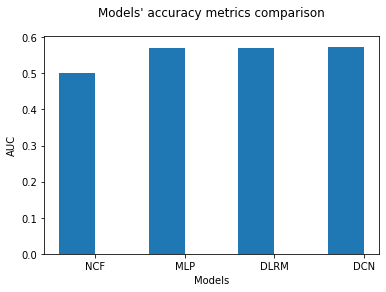

In [31]:
models_name = ["NCF", "MLP", "DLRM", "DCN"]
create_bar_chart("results.txt", models_name)